# A Simple Example of Properties of IV estimator when Instruments are Weak

In [1]:
import numpy as np
from scipy.stats import norm
from scipy.stats import gaussian_kde
import statsmodels.api as sm
from statsmodels.sandbox.regression.gmm import IV2SLS
import matplotlib.pyplot as plt

Simulation Design

In [2]:
np.random.seed(123)

n = 100
beta = 0.1  # 0.1 weak IV
# beta = 1  # 1 strong IV

# One realization
U = norm.rvs(size=n)
Z = norm.rvs(size=n)  # generate instrument
D = beta * Z + U      # generate endogenous variable
Y = D + U             # the true causal effect is 1

# First stage regression
Z1 = sm.add_constant(Z)
model_first_stage = sm.OLS(D, Z1)
results_first_stage = model_first_stage.fit()
print(results_first_stage.summary())  # first stage is very weak here when we set beta = .1

# IV regression
D1 = sm.add_constant(D)
model_iv = IV2SLS(Y, D1, Z1)
results_iv = model_iv.fit()
print(results_iv.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                 -0.006
Method:                 Least Squares   F-statistic:                    0.4359
Date:                Thu, 06 Feb 2025   Prob (F-statistic):              0.511
Time:                        01:19:15   Log-Likelihood:                -153.94
No. Observations:                 100   AIC:                             311.9
Df Residuals:                      98   BIC:                             317.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0267      0.114      0.234      0.8

Note that the instrument is weak here (strength of the instrument is controlled by setting $\beta$) -- the t-stat is smaller than any rule-of-thumb suggested in the literature (e.g. $\sqrt{10}$) .

# Run 10000 trials to evaluate distribution of the IV estimator

In [3]:
np.random.seed(123)

B = 10000  # trials
IVEst = np.zeros(B)

for i in range(B):
    U = norm.rvs(size=n)
    Z = norm.rvs(size=n)  # generate instrument
    D = beta * Z + U  # generate endogenous variable
    Y = D + U  # the true causal effect is 1

    # IV regression
    model_iv = IV2SLS(Y, D, Z)
    results_iv = model_iv.fit()
    IVEst[i] = results_iv.params[0]  # Coefficient of D

# Plot the Actual Distribution against the Normal Approximation (based on Strong Instrument Assumption)

Rejection Frequency is 0.2356 while we expect it to be around 0.05


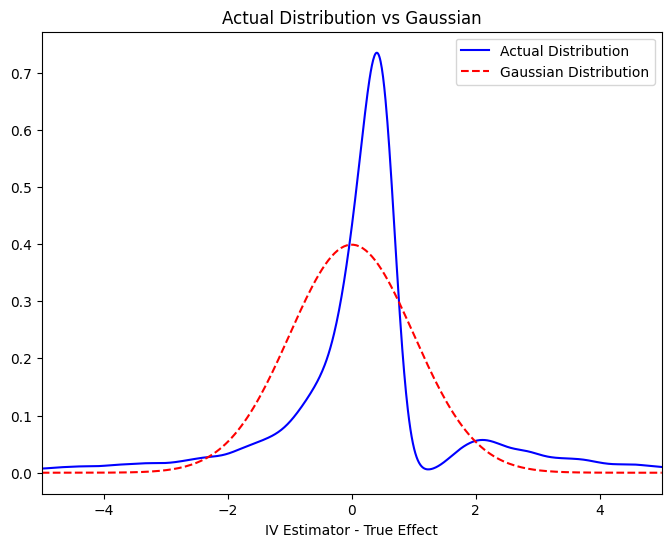

In [4]:
# Plotting the density of IVEst
plt.figure(figsize=(8, 6))
plt.xlim(-5, 5)
plt.xlabel("IV Estimator - True Effect")
plt.title("Actual Distribution vs Gaussian")

# Plotting density estimate of simulated IV coefficients
val = np.linspace(-5, 5, 200)
kde = gaussian_kde(IVEst - 1, bw_method=.001)  # Need to play with bandwidth depending on problem features.
density = kde(np.linspace(-5, 5, 1000))
plt.plot(np.linspace(-5, 5, 1000), density, color='blue', label='Actual Distribution')

# Plotting Gaussian distribution
var = (1 / (beta ** 2)) * (1 / n)  # theoretical variance of IV
sd = np.sqrt(var)
gaussian = norm.pdf(val, scale=sd)
plt.plot(val, gaussian, color='red', linestyle='--', label='Gaussian Distribution')

plt.legend()

# Calculating rejection frequency
rejection_frequency = np.sum(np.abs(IVEst - 1) / sd > 1.96) / B
print("Rejection Frequency is", rejection_frequency, "while we expect it to be around 0.05")

plt.show()